<a href="https://colab.research.google.com/github/harvalmar/PruebaGit1/blob/master/quickstarts/Image_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [19]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini 2.5 Native Image generation

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image_out.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

This notebook will show you how to use the native Image-output feature of Gemini, using the model multimodal capabilities to output both images and texts, and iterate on an image through a discussion.

This model is really good at:
* **Maintaining character consistency**: Preserve a subject’s appearance across multiple generated images and scenes
* **Performing intelligent editing**: Enable precise, prompt-based edits like inpainting (adding/changing objects), outpainting, and targeted transformations within an image
* **Compose and merge images**: Intelligently combine elements from multiple images into a single, photorealistic composite
* **Leverage multimodal reasoning**: Build features that understand visual context, such as following complex instructions on a hand-drawn diagram

Following this guide, you'll learn how to do all those things and even more.

<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#ffe680">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#ffe680">
      <h3><font color=black><font color='#217bfe'><a href="https://ai.google.dev/gemini-api/docs/billing#enable-cloud-billing">Enable billing</font></a> to use Image Generation. This is a pay-as-you-go feature (cf. <a href="https://ai.google.dev/pricing#gemini-2.5-flash-image-preview"><font color='#217bfe'>pricing</font></a>).</font></h3>
    </td>
  </tr>
</table>

[Imagen](./Get_started_imagen.ipynb) models also offer image generation but in a slightly different way as the Image-out feature has been developed to work iteratively so if you want to make sure certain details are clearly followed, and you are ready to iterate on the image until it's exactly what you envision, Image-out is for you.

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model) for more details on both features and some more advice on when to use each one.

## Setup

### Install SDK

In [20]:
%pip install -U -q "google-genai>=1.40.0" # minimum version needed for the aspect ratio

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key (or OAuth if using Vertex AI). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select a model

`gemini-2.5-flash-image` is the latest and the state-of-the-art Gemini model capable of generating images.

In [ ]:
MODEL_ID = "gemini-2.5-flash-image"

### Utils

These two functions will help you manage the outputs of the model.

Compared to when you simply generate text, this time the output will contain multiple parts, some one them being text while others will be images. You'll also have to take into account that there could be multiple images so you cannot stop at the first one.


In [ ]:
from IPython.display import display, Markdown, Image
import pathlib

# Loop over all parts and display them either as text or images
def display_response(response):
  for part in response.parts:
    if part.text:
      display(Markdown(part.text))
    elif image:= part.as_image():
      image.show()

# Save the image
# If there are multiple ones, only the last one will be saved
def save_image(response, path):
  for part in response.parts:
    if image:= part.as_image():
      image.save(path)

## Generate images

Using the Gemini Image generation model is the same as using any Gemini model: you simply call `generate_content`.

You can set the `response_modalities` to indicate to the model that you are expecting text and images in the output but it's optional as this is expected with this model.

If you just want an image and don't need text, you can set `response_modalities=['Image']`.

Here is your requested image: 

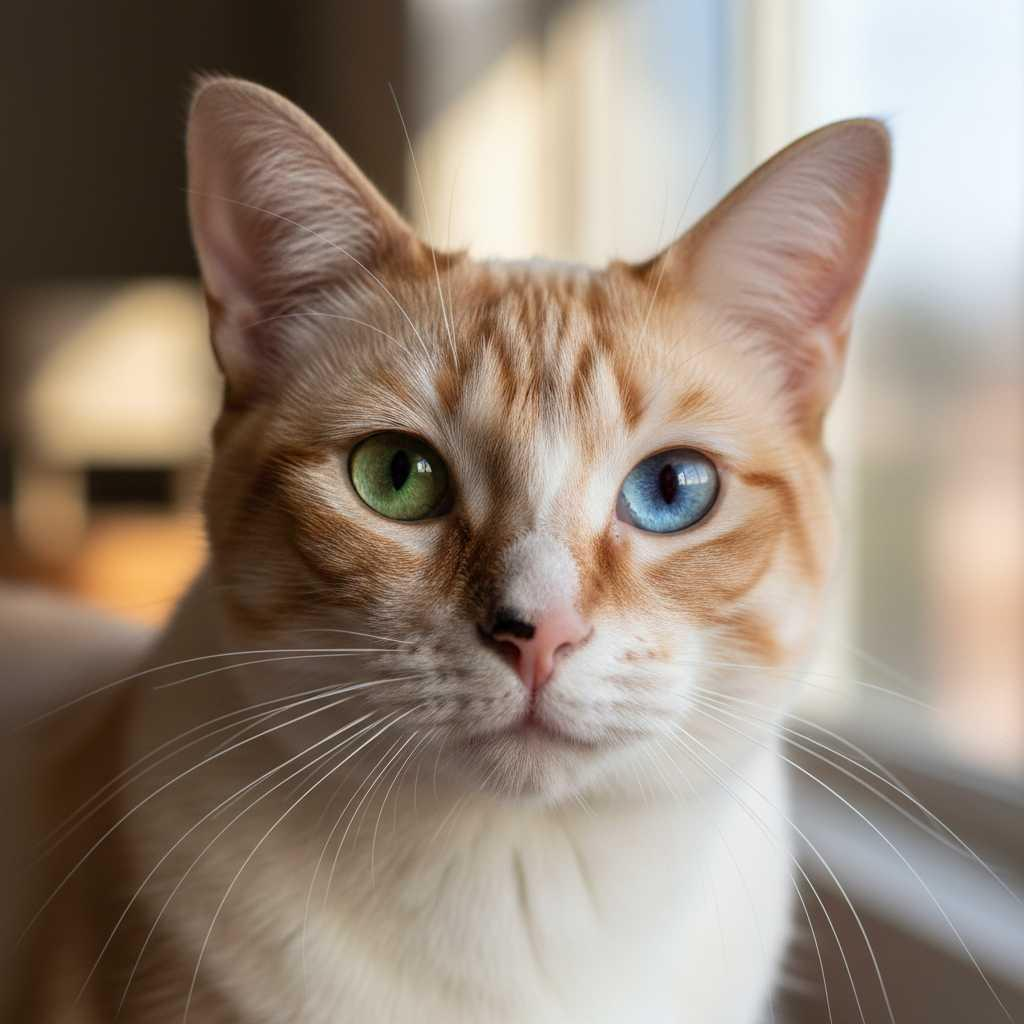

In [ ]:
prompt = 'Create a photorealistic image of a siamese cat with a green left eye and a blue right one and red patches on his face and a black and pink nose' # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'] # response_modalities=['Image'] if you only want the images
    )
)

display_response(response)
save_image(response, 'cat.png')

## Edit images

You can also do image editing, simply pass the original image as part of the prompt. Don't limit yourself to simple edit, Gemini is able to keep the character consistency and reprensent you character in different behaviors or places.

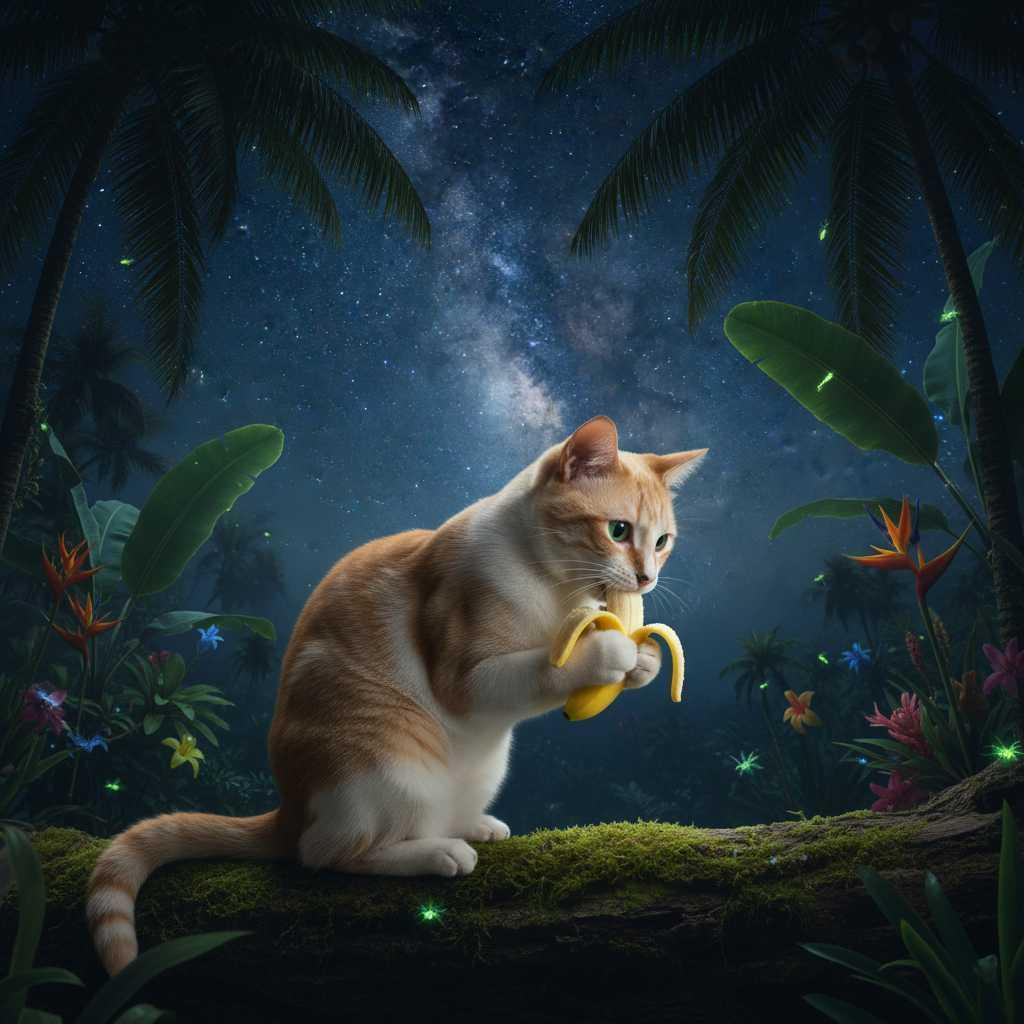

In [ ]:
import PIL

text_prompt = "Create a side view picture of that cat, in a tropical forest, eating a nano-banana, under the stars" # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png')
    ]
)

display_response(response)
save_image(response, 'cat_tropical.png')

As you can see, you can clearly recognize the same cat with its peculiar nose and eyes.

## Control aspect ratio

You can control the aspect ratio of the output image. The model's primary behavior is to match the size of your input images; otherwise, it defaults to generating square (1:1) images.

To do so, add an `aspect_ratio` value to the `image_config` as you can see in the cell below. The different ratios available and the size of the image generated are listed in this table:

| Aspect ratio | Resolution | Tokens |
| --- | --- | --- |
| 1:1 | 1024x1024 | 1290 |
| 2:3 | 832x1248 | 1290 |
| 3:2 | 1248x832 | 1290 |
| 3:4 | 864x1184 | 1290 |
| 4:3 | 1184x864 | 1290 |
| 4:5 | 896x1152 | 1290 |
| 5:4 | 1152x896 | 1290 |
| 9:16 | 768x1344 | 1290 |
| 16:9 | 1344x768 | 1290 |
| 21:9 | 1536x672 | 1290 |

Note that the number of tokens stays the same for all aspect ratio.

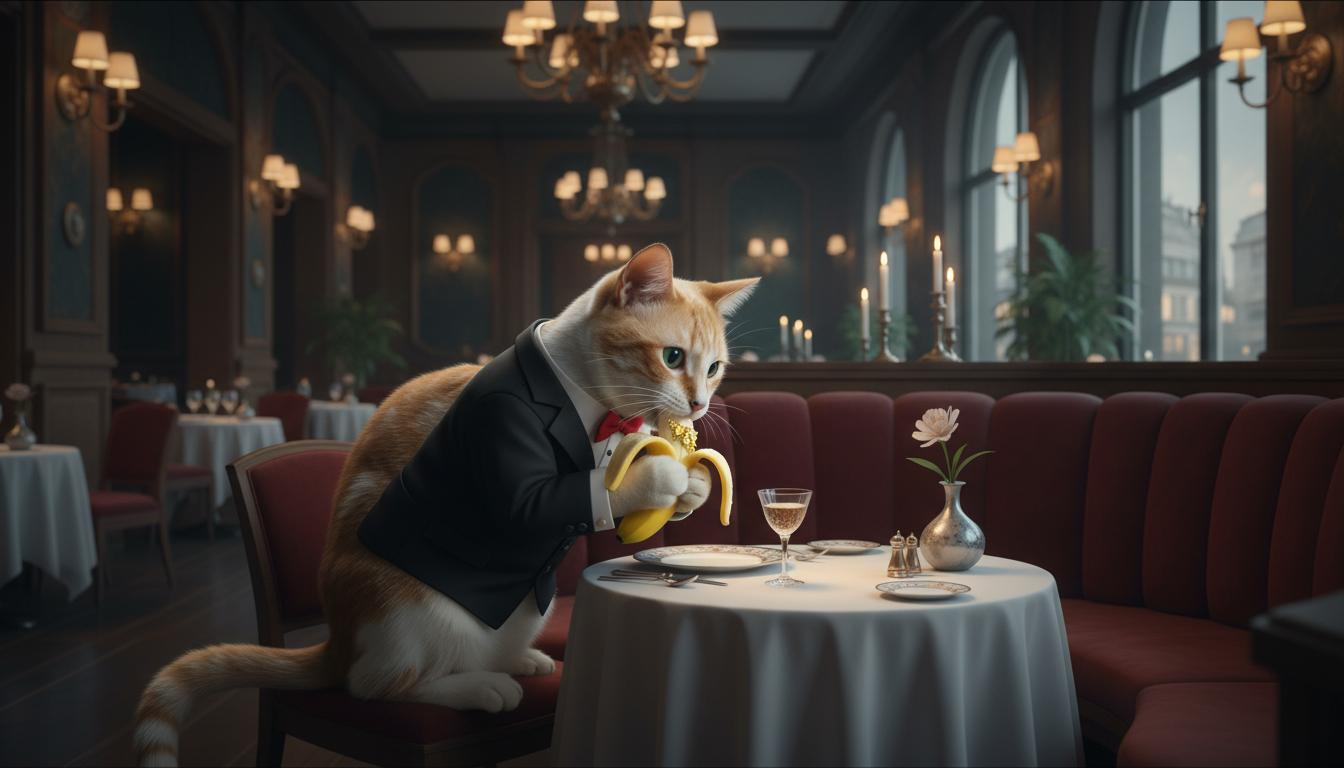

In [ ]:
import PIL

text_prompt = "Now the cat should keep the same attitude, but be well dressed in fancy restaurant and eat a fancy nano banana." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat_tropical.png')
    ],
    config=types.GenerateContentConfig(
        response_modalities=["IMAGE"],
        image_config=types.ImageConfig(
            aspect_ratio="16:9",
        )
    )

)

display_response(response)
save_image(response, 'cat_resaurant.png')

## Get multiple images (ex: tell stories)

So far you've only generated one image per call, but you can request way more than that! Let's try a baking receipe or telling a story.

In [ ]:
prompt = "Show me how to bake macarons with images" # @param ["Show me how to bake macarons with images","Create a beautifully entertaining 8 part story with 8 images with two blue characters and their adventures in the 1960s music scene. The story is thrilling throughout with emotional highs and lows and ending on a great twist and high note. Do not include any words or text on the images but tell the story purely through the imagery itself. "] {"allow-input":true}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
)

display_response(response)

# Be careful; long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here are some examples of what it should look like when you run it when asking for a story, or for a baking receipe:

----------
**Prompt**: *Create a beautifully entertaining 8 part story with 8 images with two blue characters and their adventures in the 1960s music scene. The story is thrilling throughout with emotional highs and lows and ending on a great twist and high note. Do not include any words or text on the images but tell the story purely through the imagery itself.*
![Azure tone story](https://storage.googleapis.com/generativeai-downloads/images/azuretones.png)
(Images have been stitched together)

----------
**Prompt**: *Show me how to bake macarons with images*


That sounds delicious! Here's a simplified guide on how to bake macarons. While it can be a bit tricky, practice makes perfect!

**Ingredients you'll need:**

*   **For the Macaron Shells:**
    *   100g almond flour
    *   100g powdered sugar
    *   75g granulated sugar
    *   2 egg whites (aged for a day or two at room temp, if possible, for better stability)
    *   Pinch of salt (optional)
    *   Food coloring (gel or powder, not liquid)

*   **For the Filling:** (Buttercream, ganache, or jam are popular choices)

---

**Step 1: Prepare your dry ingredients.**
Sift together the almond flour and powdered sugar into a bowl. This step is crucial for achieving smooth macaron shells, as it removes any lumps.


![Macaron prepartation step 1](https://storage.googleapis.com/generativeai-downloads/images/macaron_step1.png)

**Step 2: Make the meringue.**
In a separate, clean bowl, beat the egg whites with a pinch of salt (if using) until foamy. Gradually add the granulated sugar, continuing to beat until you achieve stiff, glossy peaks. If you're using food coloring, add it now. The meringue should be firm enough that you can turn the bowl upside down without it falling out.

![Macaron prepartation step 2](https://storage.googleapis.com/generativeai-downloads/images/macaron_step2.png)

**Step 3: Combine dry ingredients with meringue (Macaronage).**
Gently fold the sifted almond flour and powdered sugar into the meringue in two or three additions. This is called "macaronage" and is the most critical step. You want to mix until the batter flows like "lava" or a slowly ribboning consistency when you lift your spatula. Be careful not to overmix, or your macarons will be flat; under-mixing will result in lumpy shells.

![Macaron prepartation step 3](https://storage.googleapis.com/generativeai-downloads/images/macaron_step3.png)

**Step 4: Pipe the macarons.**
Transfer the batter to a piping bag fitted with a round tip. Pipe uniform circles onto baking sheets lined with parchment paper or silicone mats. Leave some space between each macaron.

![Macaron prepartation step 4](https://storage.googleapis.com/generativeai-downloads/images/macaron_step4.png)

**Step 5: Tap and Rest.**
Firmly tap the baking sheets on your counter several times to release any air bubbles. Use a toothpick to pop any remaining bubbles. This helps create smooth tops and the characteristic "feet." Let the piped macarons rest at room temperature for 30-60 minutes, or until a skin forms on top. When you gently touch a shell, it shouldn't feel sticky. This "drying" step is essential for the feet to develop properly.

![Macaron prepartation step 5](https://storage.googleapis.com/generativeai-downloads/images/macaron_step5.png)

**Step 6: Bake the macarons.**
Preheat your oven to 300°F (150°C). Bake one tray at a time for 12-15 minutes. The exact time can vary by oven. They are done when they have developed "feet" and don't wobble when gently touched.

**Step 7: Cool and Fill.**
Once baked, let the macaron shells cool completely on the baking sheet before carefully peeling them off. This prevents them from breaking.  Then, match them up by size and pipe or spread your chosen filling onto one shell before sandwiching it with another.

![Macaron prepartation step 7](https://storage.googleapis.com/generativeai-downloads/images/macaron_step7.png)

Finally, let them mature in the refrigerator for at least 24 hours. This allows the flavors to meld and the shells to soften to the perfect chewy consistency.

Enjoy your homemade macarons!

-----

## Chat mode (recommended method)

So far you've used unary calls, but Image-out is actually made to work better with chat mode as it's easier to iterate on an image turn after turn.

In [ ]:
chat = client.chats.create(
    model=MODEL_ID,
)

Here is an image of a plastic toy fox figurine in a kid's bedroom, with accessories: 

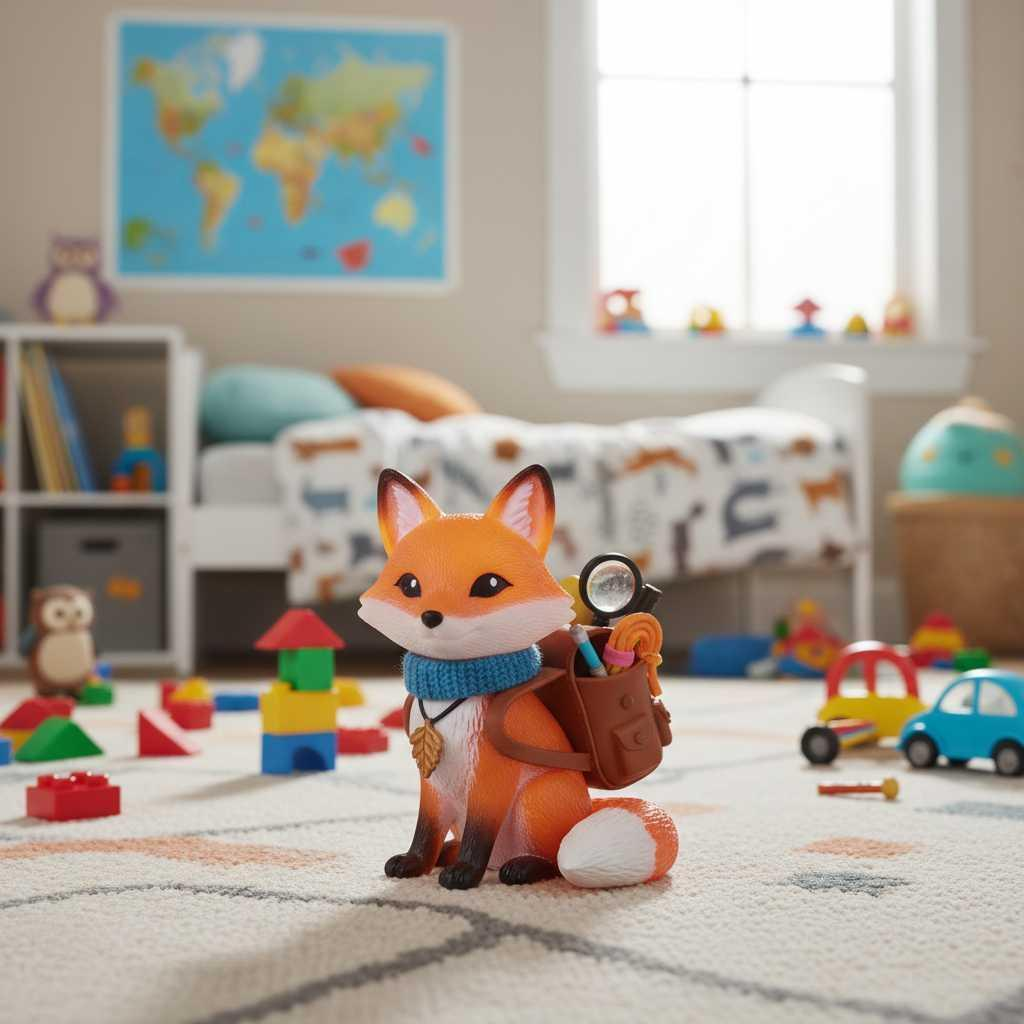

In [ ]:
message = "create a image of a plastic toy fox figurine in a kid's bedroom, it can have accessories but no weapon" # @param {type:"string"}

response = chat.send_message(message)
display_response(response)
save_image(response, "figurine.png")

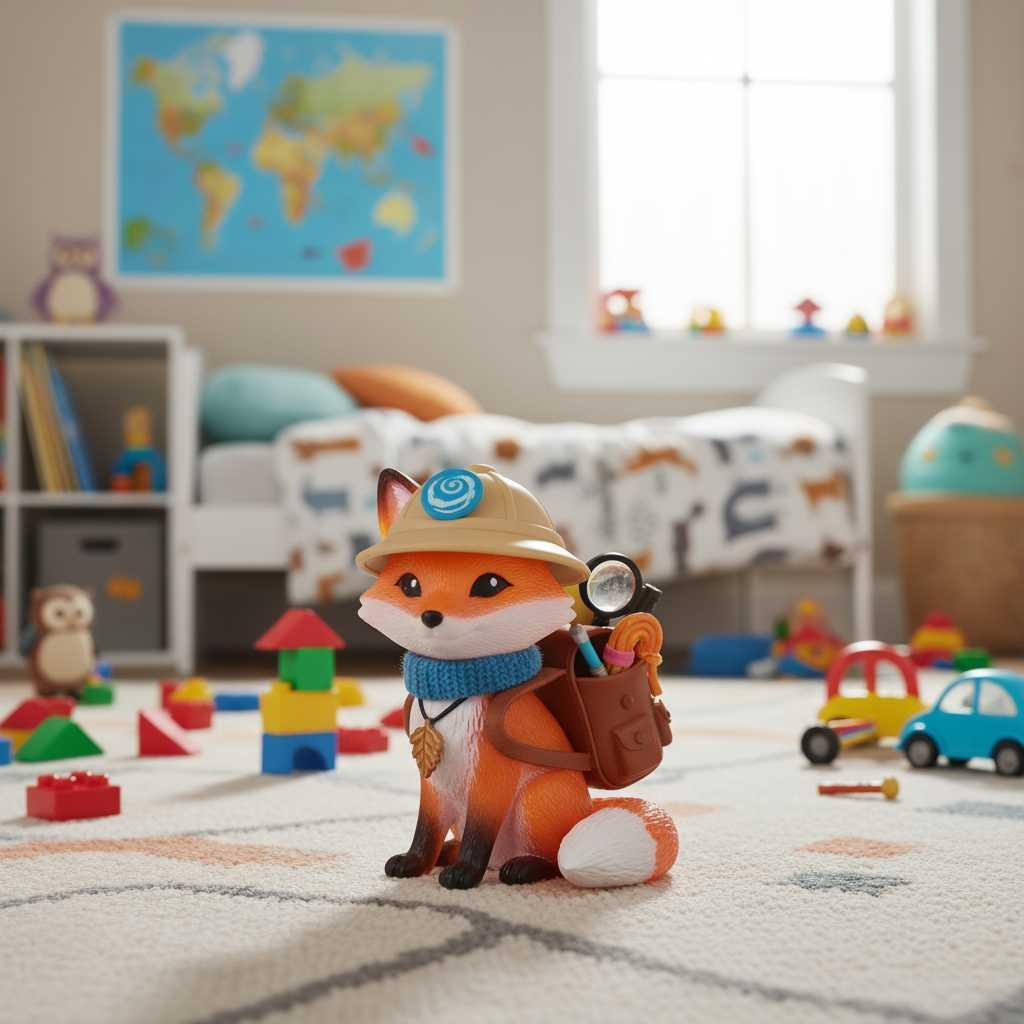

In [ ]:
message = "Add a blue planet on the figuring's helmet or hat (add one if needed)" # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

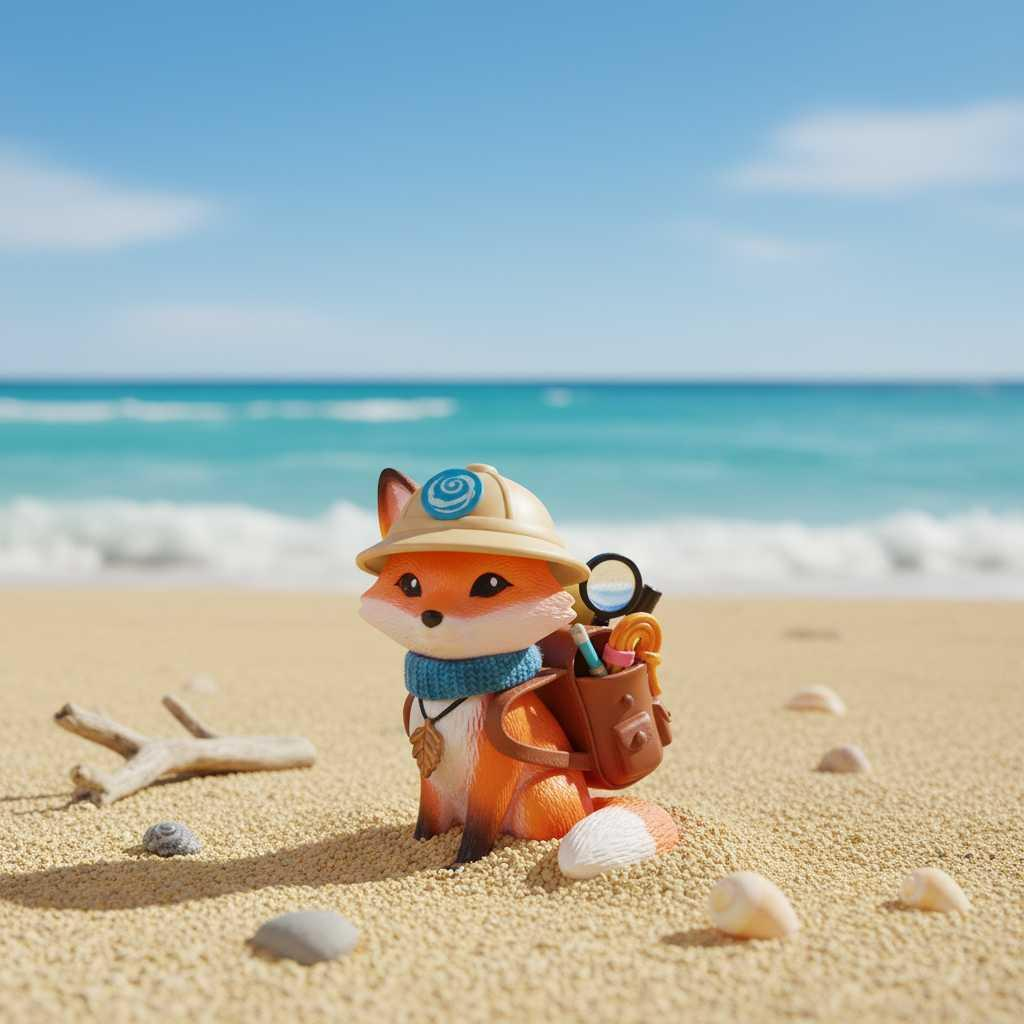

In [ ]:
message = 'Move that figurine on a beach' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

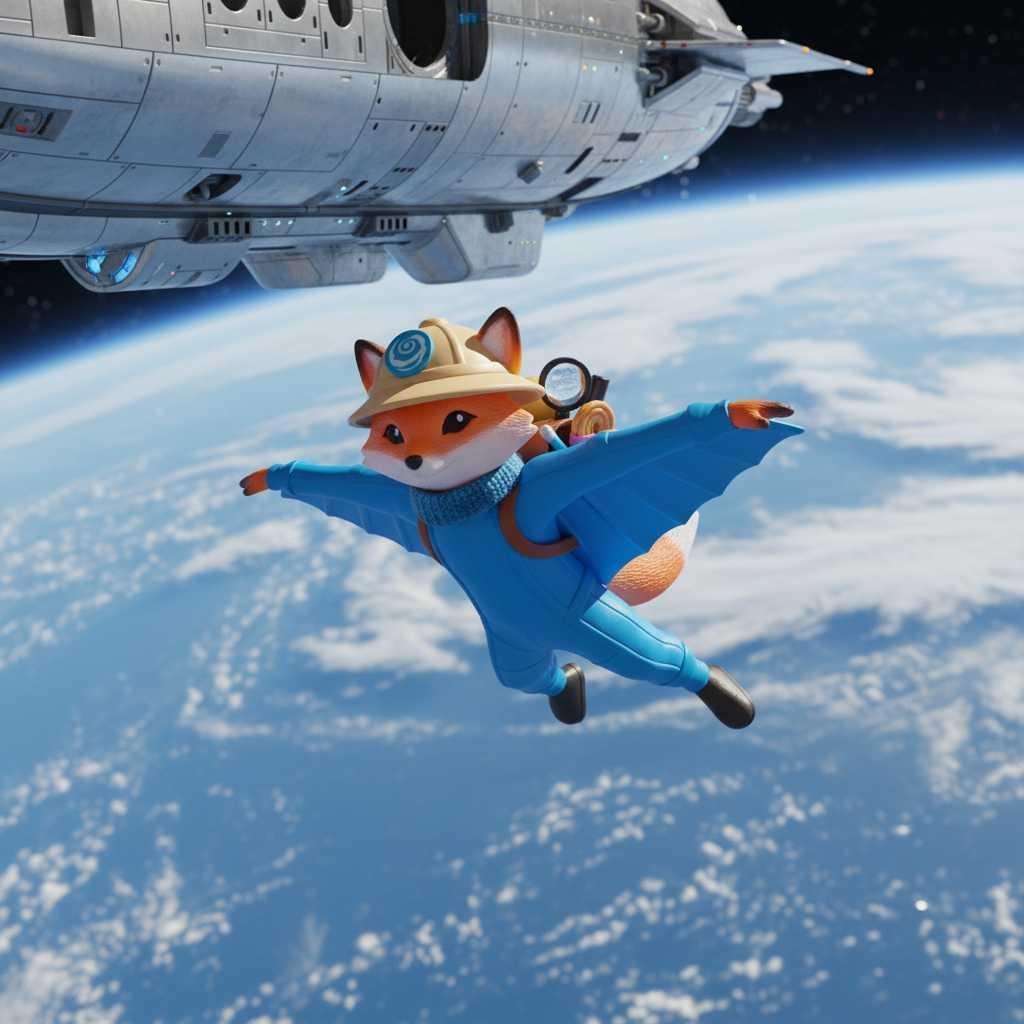

In [ ]:
message = 'Now it should be base-jumping from a spaceship with a wingsuit' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

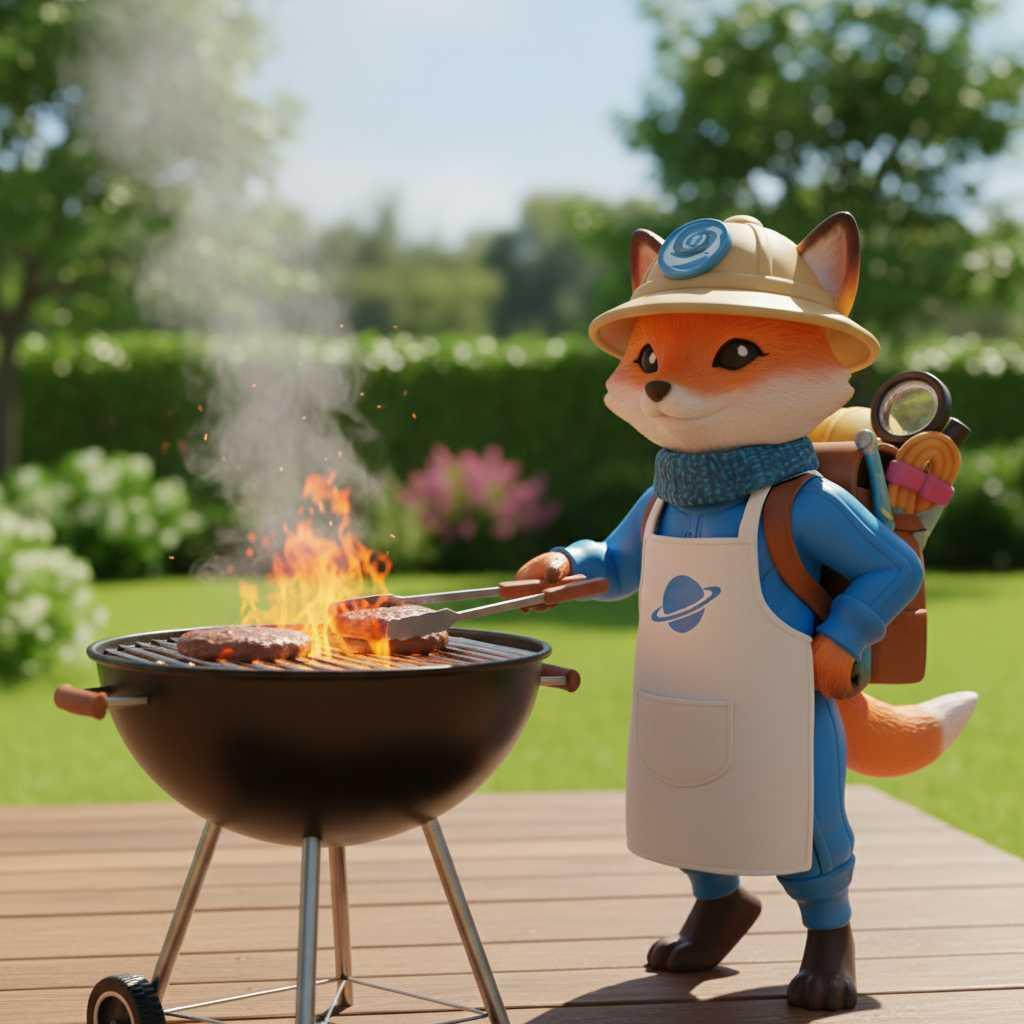

In [ ]:
message = 'Cooking a barbecue with an apron' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

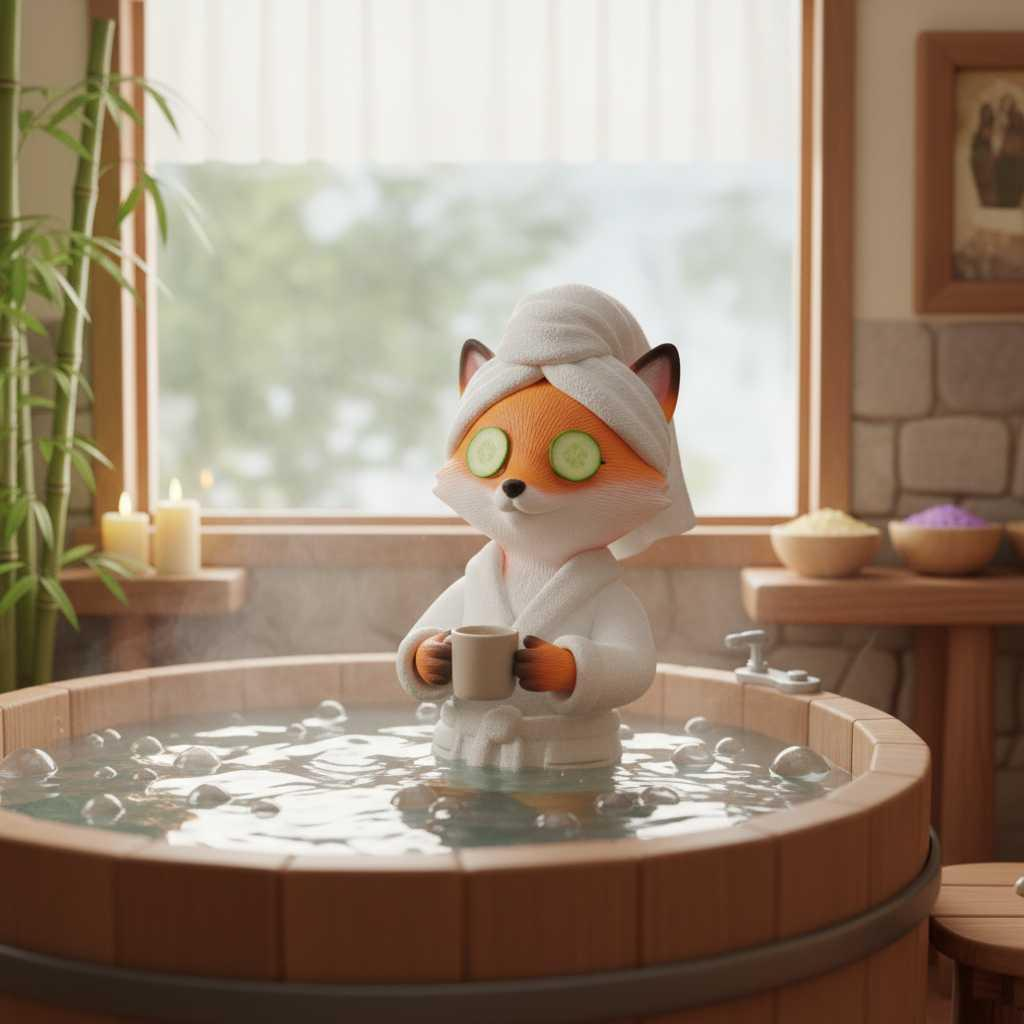

In [ ]:
message = 'What about chilling in a spa?' # @param {type:"string"}
response = chat.send_message(message)
display_response(response)

You can also control the aspect ratio of the output image in chat mode.

To do so, add an `aspect_ratio` value to the `image_config` as you can see in the cell below.

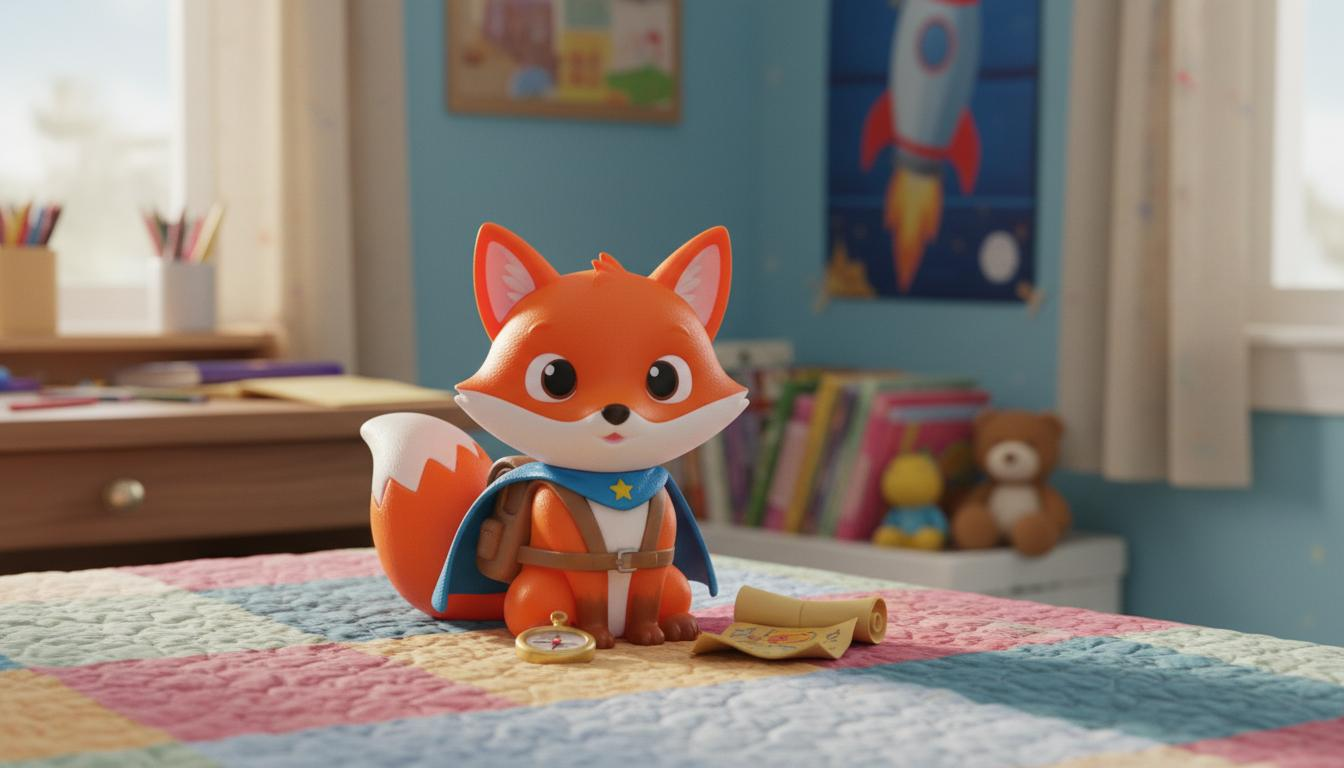

In [ ]:
message = "create a image of a plastic toy fox figurine in a kid's bedroom, it can have accessories but no weapon", # @param {type:"string"}
response = chat.send_message(
    message,
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(aspect_ratio="16:9"),
    ),
)
display_response(response)

## Mix multiple pictures

You can also mix multiple images (up to 3), either because there are multiple characters in your image, or because you want to hightlight a certain product, or set the background.

What a fun idea! Here’s that brave figurine riding the cat through a fantastical world. 

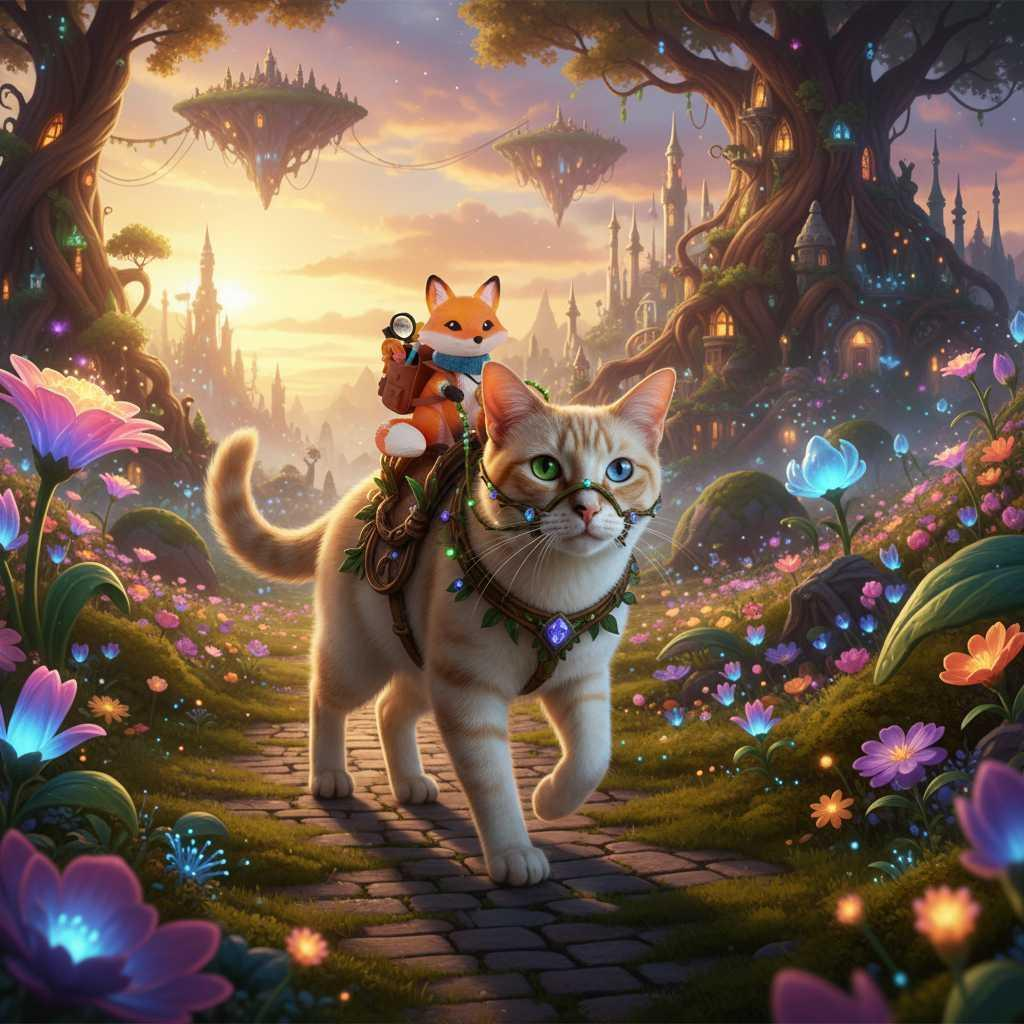

In [ ]:
import PIL

text_prompt = "Create a picture of that figurine riding that cat in a fantasy world." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png'),
        PIL.Image.open('figurine.png')
    ],
)

display_response(response)

## Other cool prompts to test

### Back to the 80s

Here's a photograph of the cat as if they were living in the 1980s, complete with the distinct fashion, hairstyles, and overall atmosphere of that time period! 

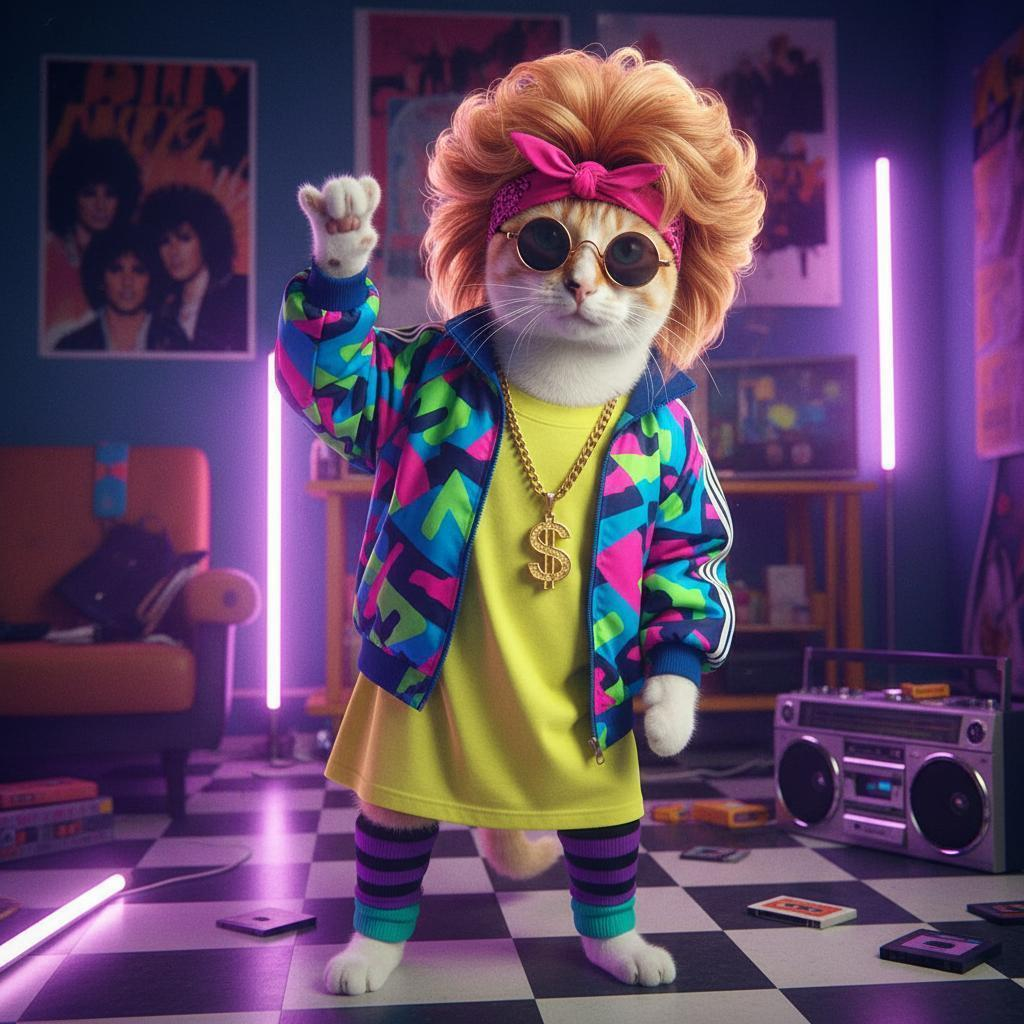

In [ ]:
text_prompt = "Create a photograph of the person in this image as if they were living in the 1980s. The photograph should capture the distinct fashion, hairstyles, and overall atmosphere of that time period." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png')
    ]
)

display_response(response)
save_image(response, 'cat_80s.png')

### Mini-figurine

Here's your figurine!


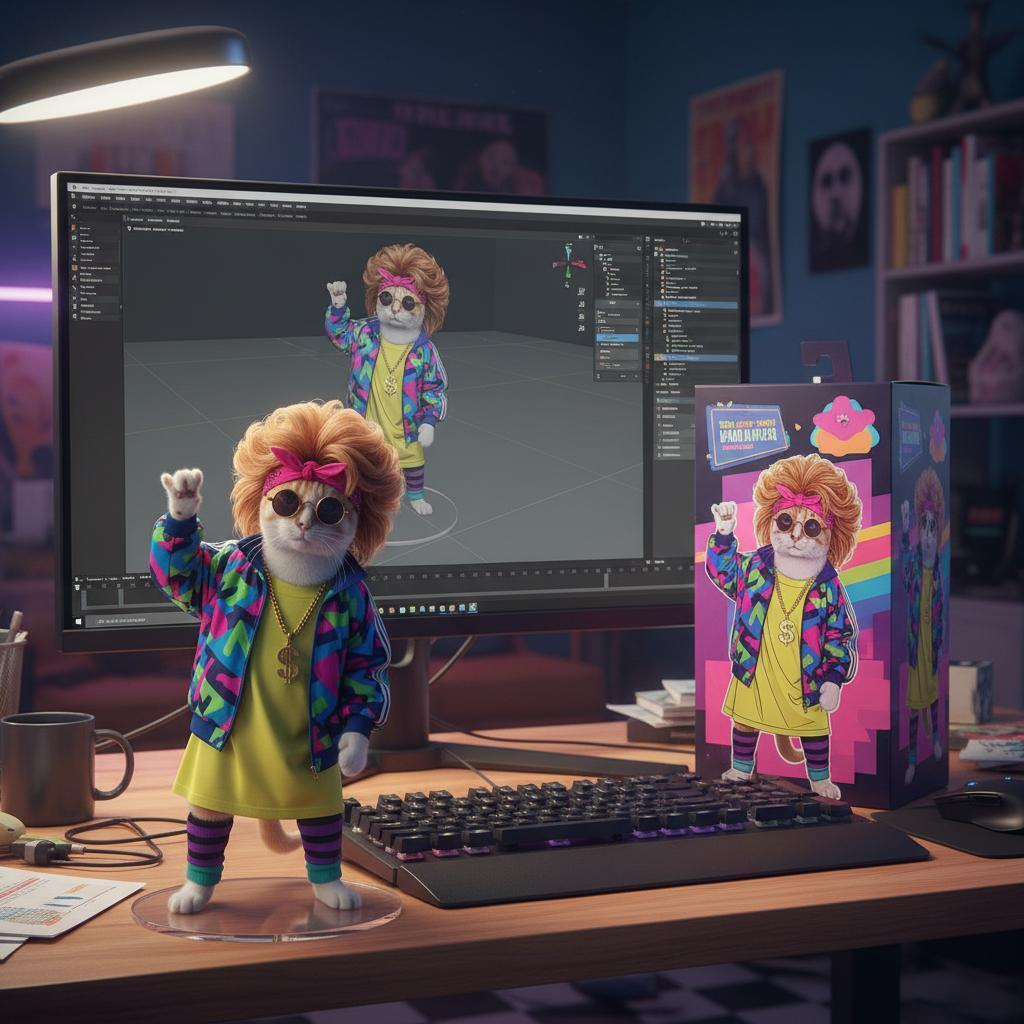

In [ ]:
text_prompt = "create a 1/7 scale commercialized figurine of the characters in the picture, in a realistic style, in a real environment. The figurine is placed on a computer desk. The figurine has a round transparent acrylic base, with no text on the base. The content on the computer screen is a 3D modeling process of this figurine. Next to the computer screen is a toy packaging box, designed in a style reminiscent of high-quality collectible figures, printed with original artwork. The packaging features two-dimensional flat illustrations." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat_80s.png')
    ]
)

display_response(response)

### Stickers

Here's your Pop Art sticker with a dramatic expression and stylized text! 

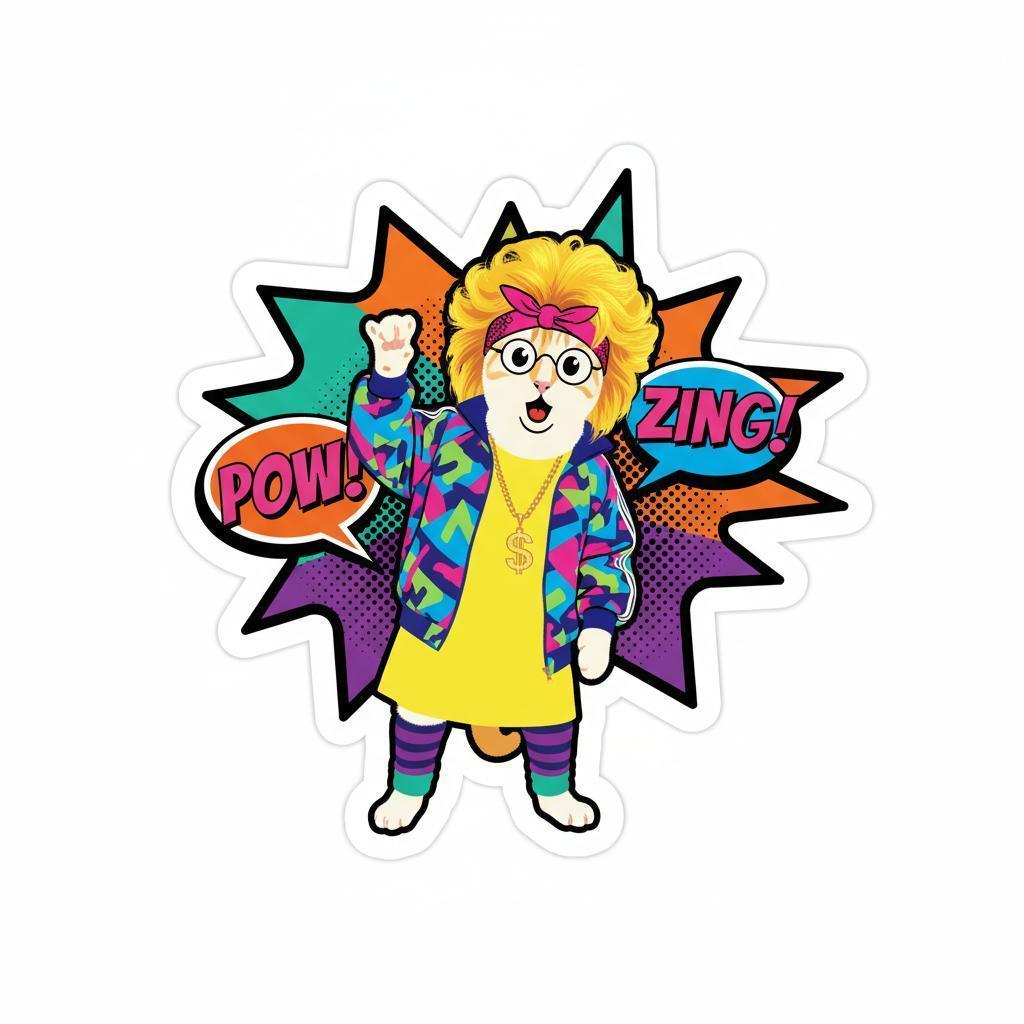

In [ ]:
text_prompt = "Create a single sticker in the distinct Pop Art style. The image should feature bold, thick black outlines around all figures, objects, and text. Utilize a limited, flat color palette consisting of vibrant primary and secondary colors, applied in unshaded blocks, but maintain the person skin tone. Incorporate visible Ben-Day dots or halftone patterns to create shading, texture, and depth. The subject should display a dramatic expression. Include stylized text within speech bubbles or dynamic graphic shapes to represent sound effects (onomatopoeia). The overall aesthetic should be clean, graphic, and evoke a mass-produced, commercial art sensibility with a polished finish. The user's face from the uploaded photo must be the main character, ideally with an interesting outline shape that is not square or circular but closer to a dye-cut pattern" # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat_80s.png')
    ]
)

display_response(response)

### Multi-image fusion
Tip: Combine multiple images into a single ‘collage’ first if you need to go beyond the image upload limit.


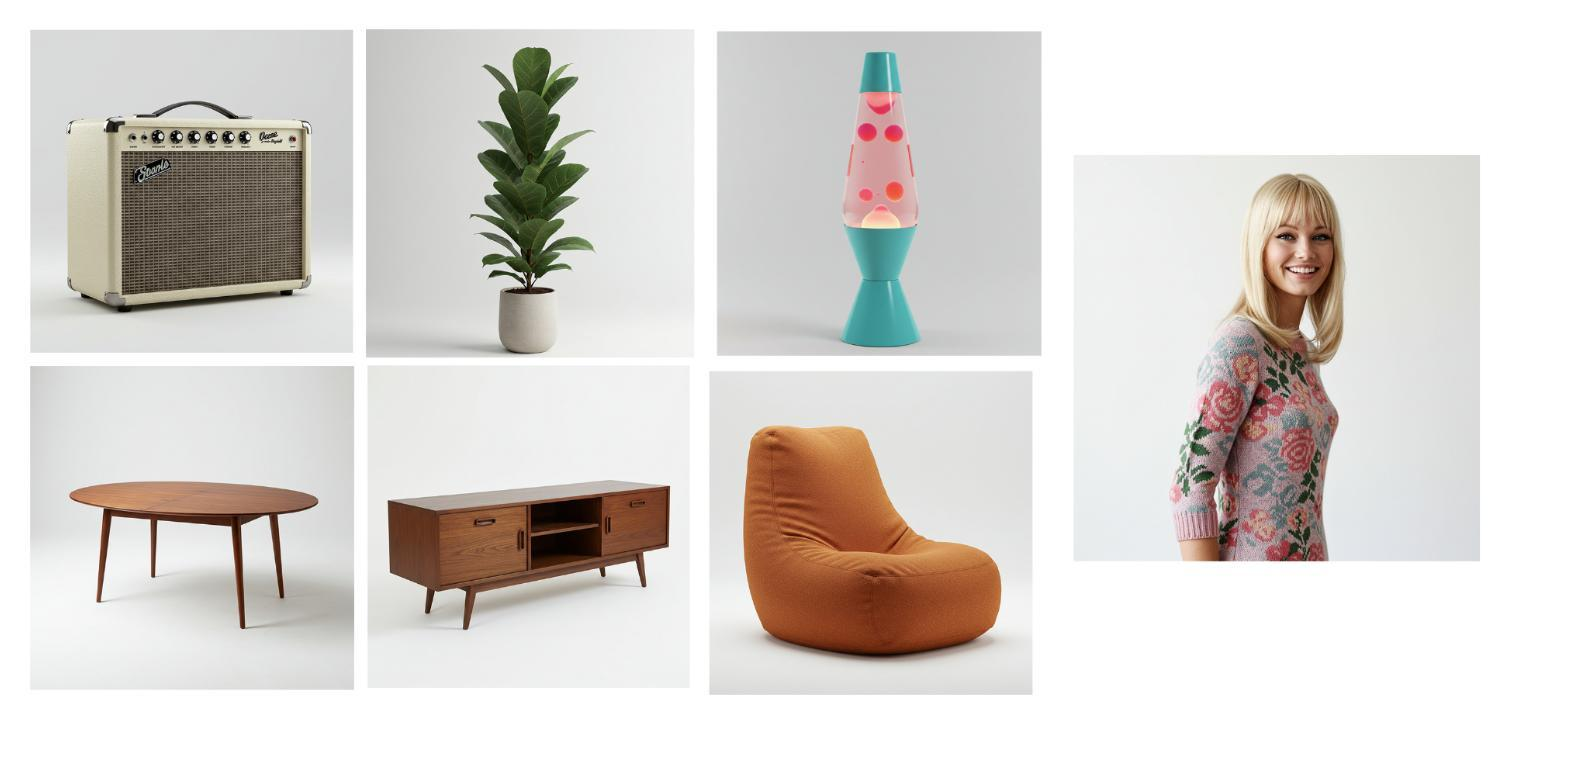

Here's a 60s inspired fashion editorial photoshoot incorporating all the elements from the images you provided:



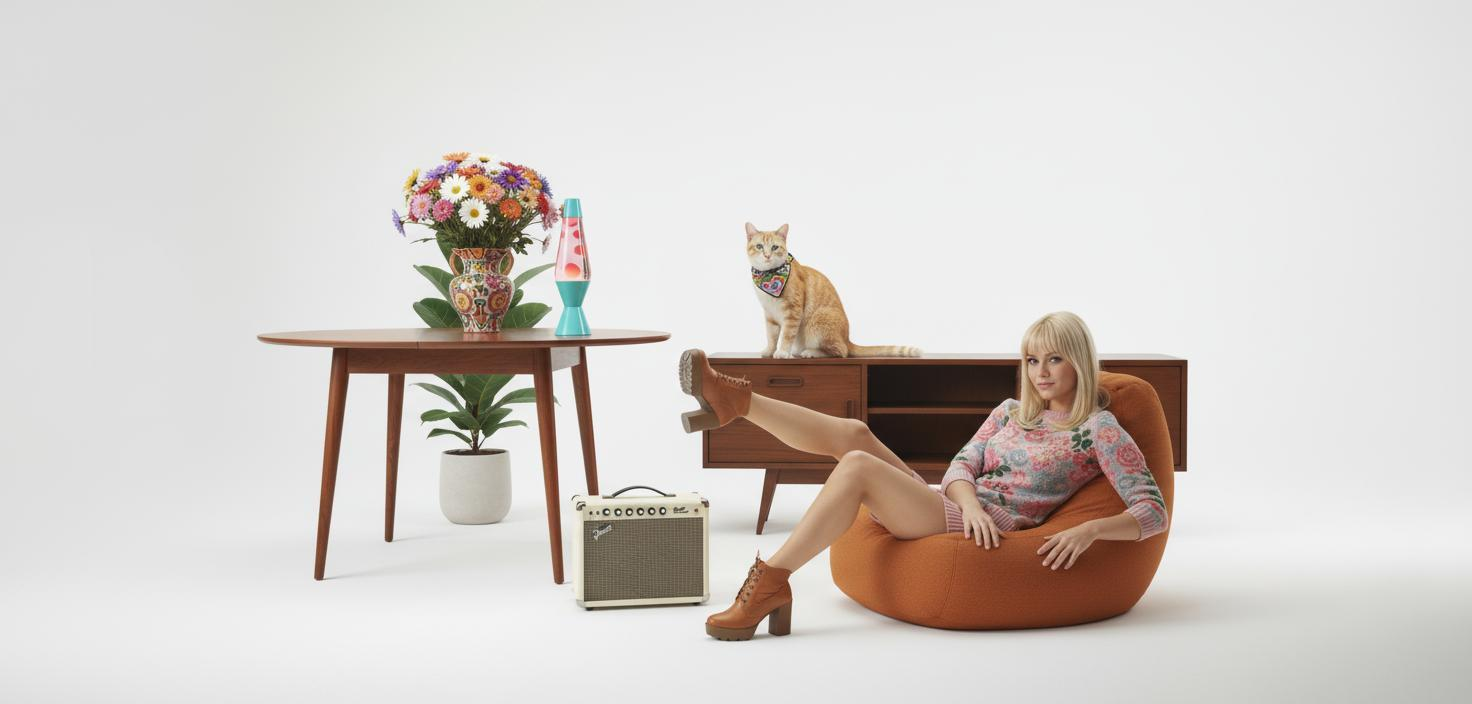

In [ ]:
text_prompt = "Combine everything in these images to create a 60s inspired fashion editorial photoshoot" # @param {type:"string"}

!wget "https://storage.googleapis.com/generativeai-downloads/images/Multiple_images.png" -O "Multiple_images.png" -q
display(Image('Multiple_images.png'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png'),
        PIL.Image.open('Multiple_images.png')
    ]
)

display_response(response)

### Colorize black and white images

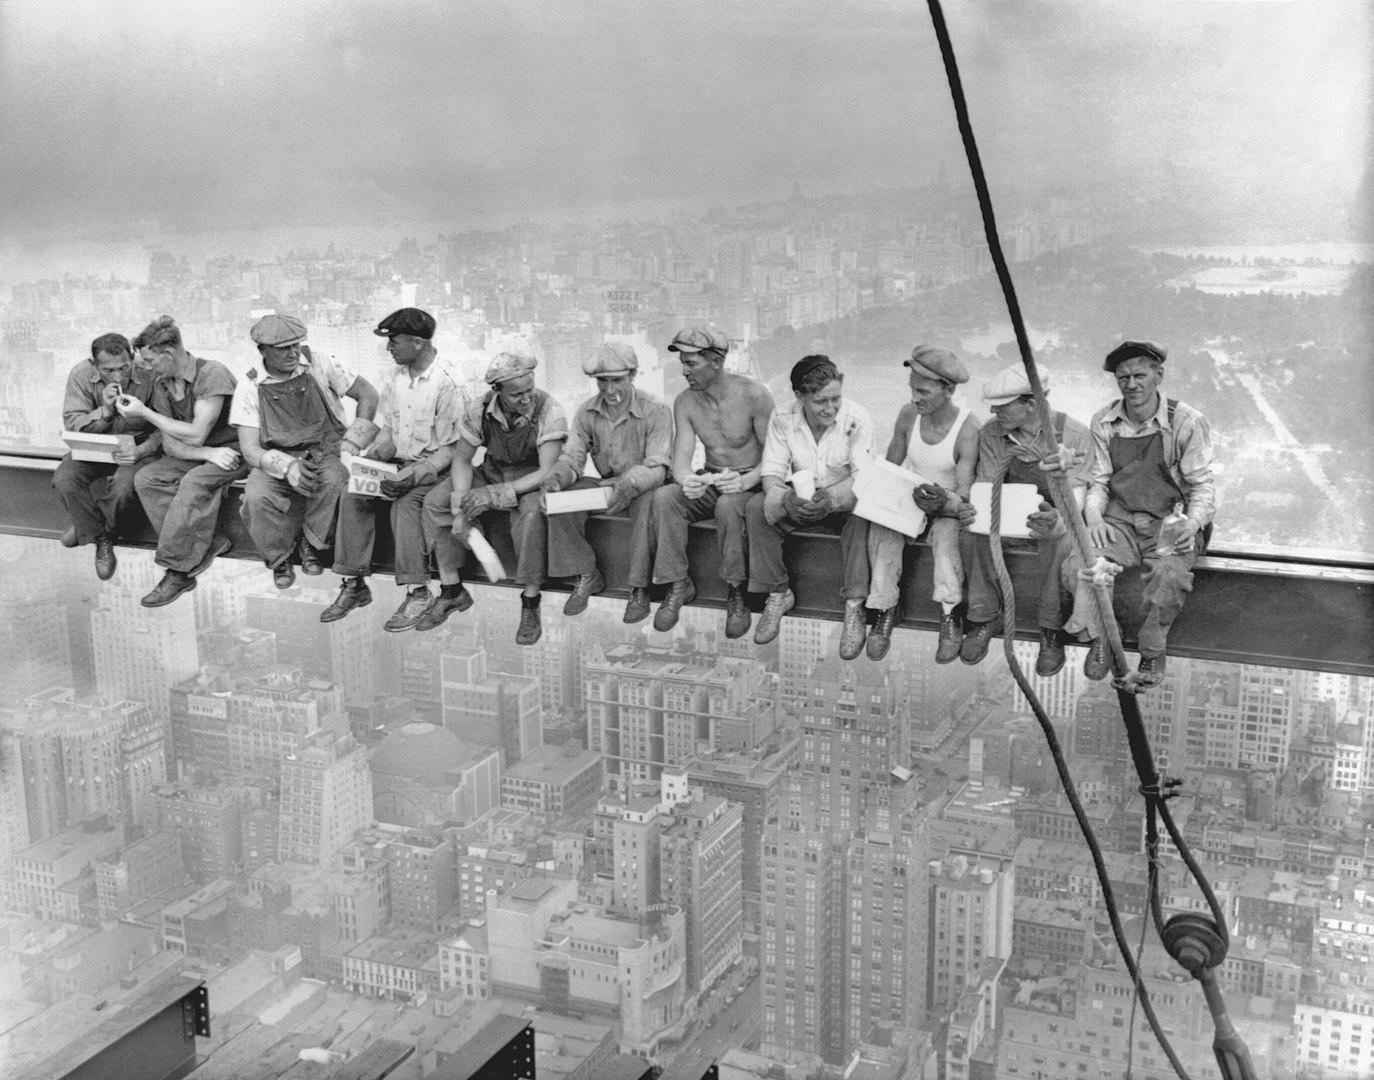

Here's the restored and colorized version of the iconic 1932 image: 

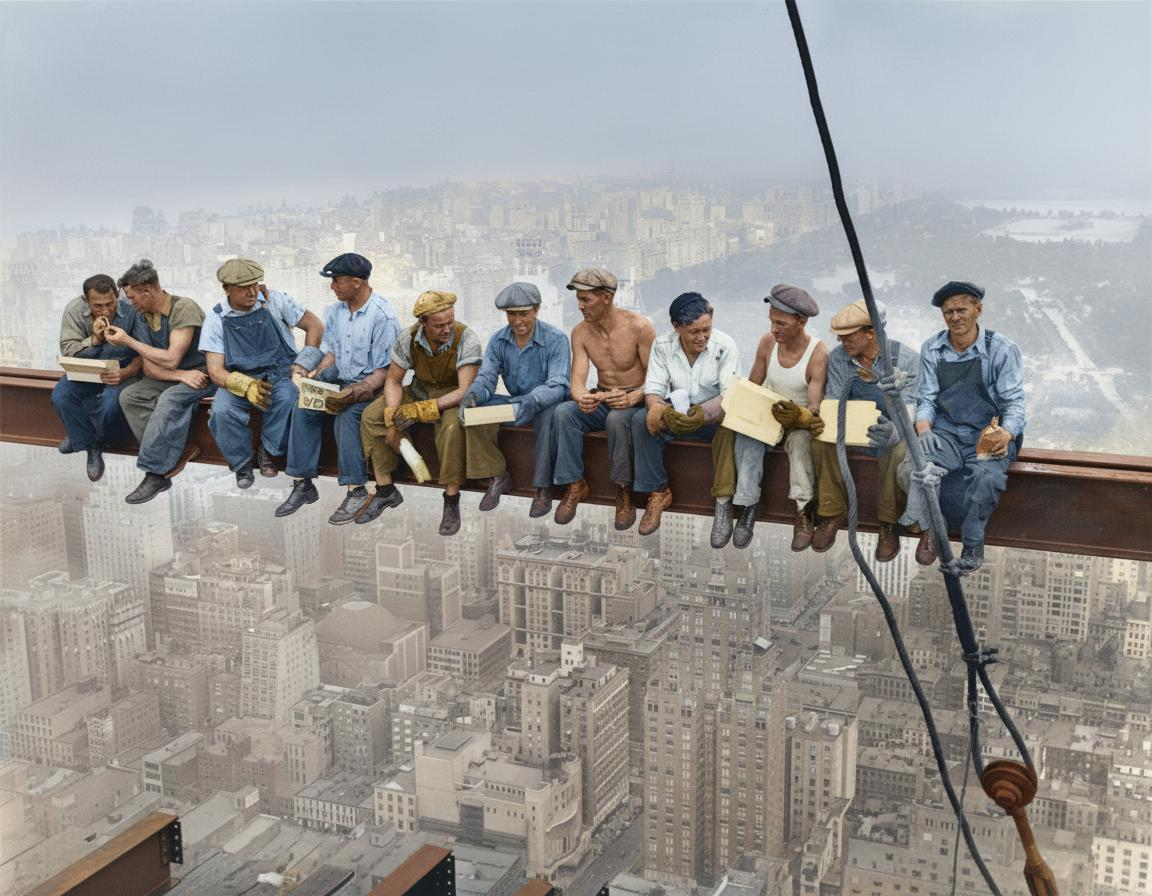

In [ ]:
text_prompt = "Restore and colorize this image from 1932." # @param {type:"string"}

# Thanks to the wikimedia foundation for hosting this historical picture
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Lunch_atop_a_Skyscraper_-_Charles_Clyde_Ebbets.jpg/1374px-Lunch_atop_a_Skyscraper_-_Charles_Clyde_Ebbets.jpg" -O "Lunch_atop_a_Skyscraper.jpg" -q
display(Image('Lunch_atop_a_Skyscraper.jpg'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Lunch_atop_a_Skyscraper.jpg')
    ]
)

display_response(response)

### Google Map transformation


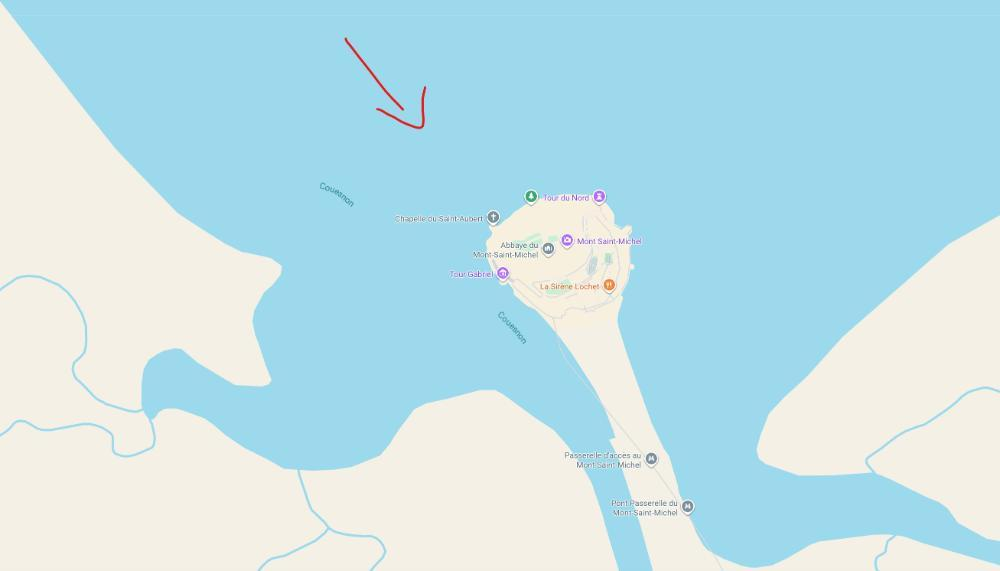

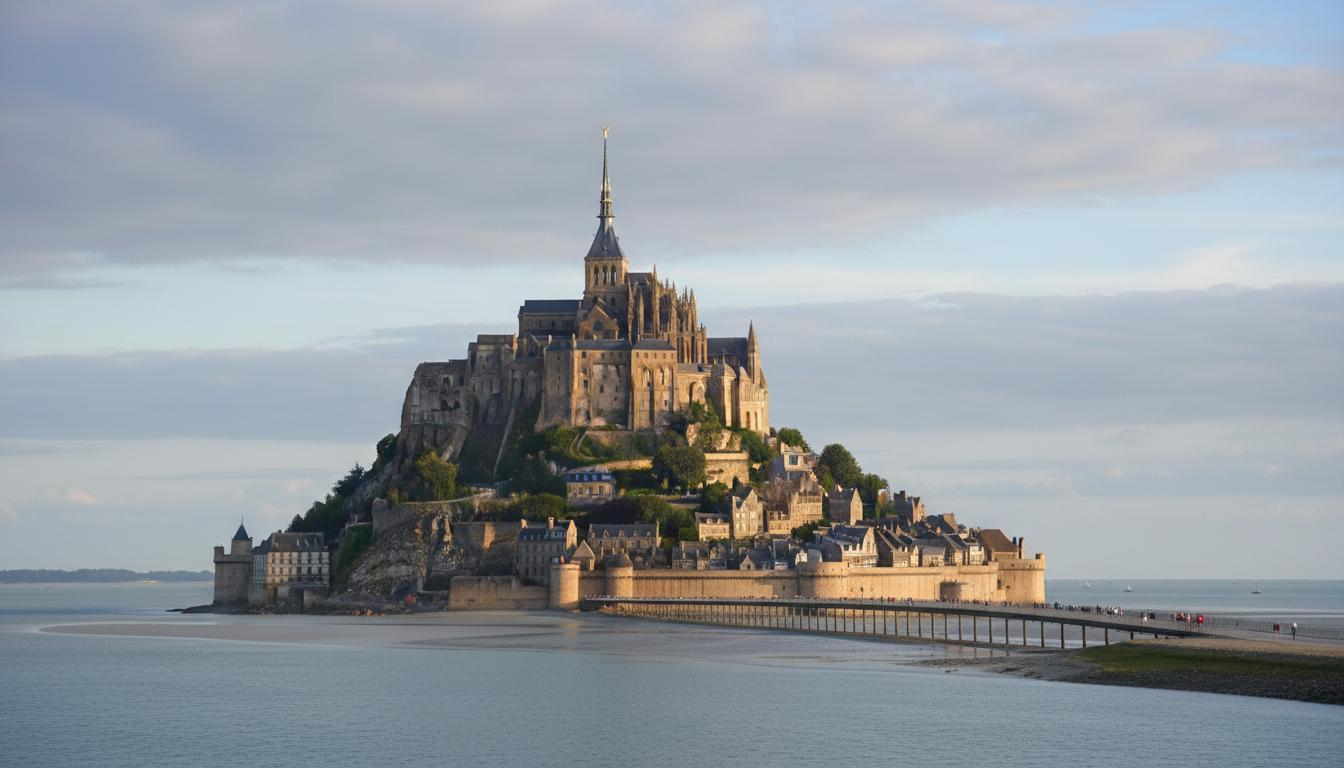

In [ ]:
text_prompt = "Show me what we see from the red arrow" # @param {type:"string"}

!wget "https://storage.googleapis.com/generativeai-downloads/images/Mont_St_Michel.png" -O "Mont_St_Michel.png" -q
display(Image('Mont_St_Michel.png'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Mont_St_Michel.png')
    ]
)

display_response(response)

### Isometric landmark


Here is Mont Saint-Michel in the style of Theme Park! 

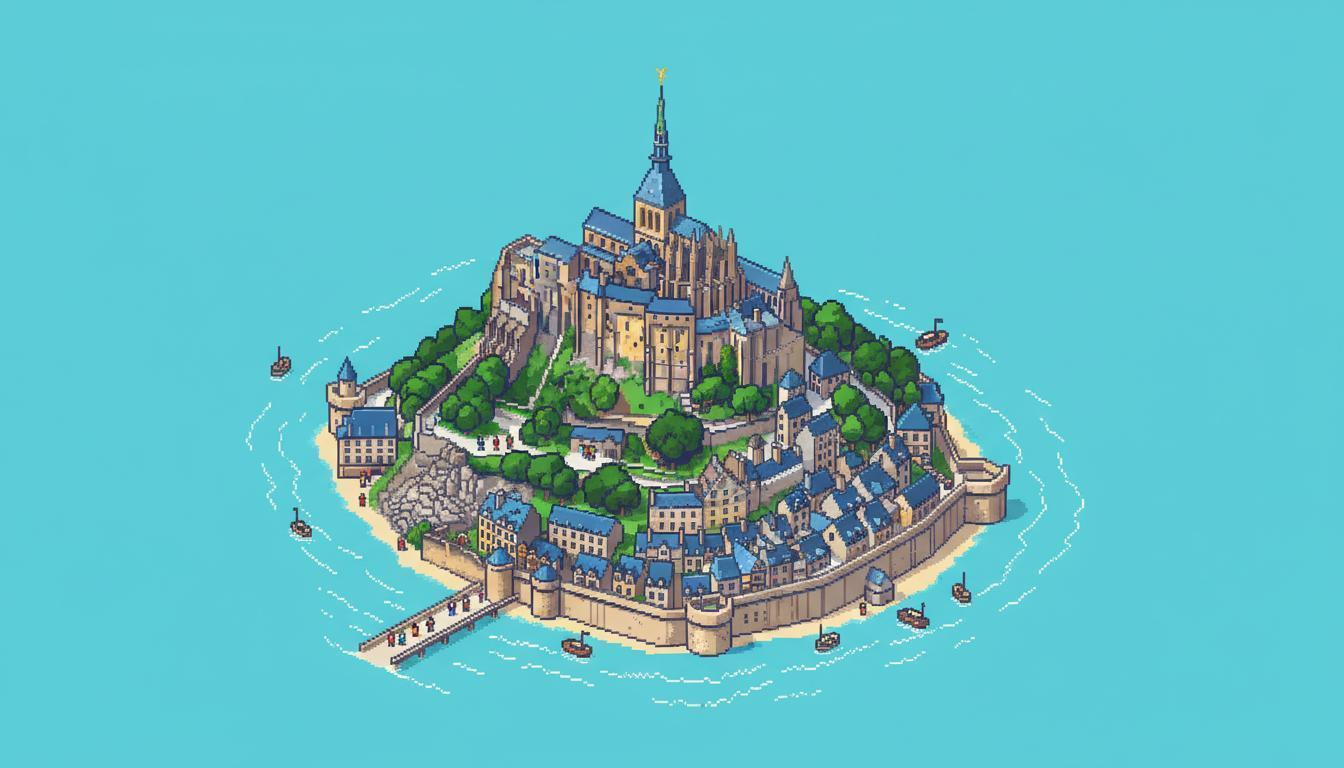

In [ ]:
text_prompt = "Take this location and make the landmark an isometric image (building only), in the style of the game Theme Park." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Mont_St_Michel.png')
    ]
)

display_response(response)

## Next Steps
### Useful documentation references:

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#gemini) for more details about the image generation capabilities of the model. To improve your prompting skills, check out the [prompt guide](https://ai.google.dev/gemini-api/docs/image-generation#prompt-guide) for great advices on creating your prompts.

### Check a more complex example
[Illustrate a book](../examples/Book_illustration.ipynb): Use Gemini to create illustration for an open-source book and audiobook

### Play with the AI Studio apps

Theses 5 AI Studio apps are all great showcases of Gemini image generation capabilities:
* [Past Forward](https://aistudio.google.com/apps/bundled/past_forward) lets you travel through time
* [Home Canvas](https://aistudio.google.com/apps/bundled/home_canvas) lets your try out new furniture
* [Gembooth](https://aistudio.google.com/apps/bundled/gembooth) places you into a comic book or a Renaissance painting
* [Gemini Co-drawing](https://aistudio.google.com/apps/bundled/codrawing) lets you draw alongside with Gemini
* [Pixshop](https://aistudio.google.com/apps/bundled/pixshop), an AI-powered image editor

### Check-out Imagen as well:
The [Imagen](https://ai.google.dev/gemini-api/docs/imagen) model is another way to generate images. Check out the [Get Started with Imagen notebook](./Get_started_imagen.ipynb) to start playing with it too.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.
